In [1]:
from models import *
from datasets import *
from utils import *
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import torch
from tqdm import tqdm

model_dir = '/home/hubble/data/trained_models'
data_dir = '/home/hubble/data/decaying_turbulence/velocity'
device = get_device()

cm = 1/2.54

rename_dict = {
    "DSCMS":     "Baseline",
    "DSCMS_C4":  "$C_4$",
    "DSCMS_D4":  "$D_4$",
    "DSCMS_C8":  "$C_8$",
    "DSCMS_SO2": "SO$(2)$",
}

2024-05-08 18:11:45.221755: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-08 18:11:45.958748: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Using cuda device.


In [2]:
def NER(pred, y):
    assert pred.ndim == y.ndim in [2, 3], "Input can't be a minibatch."
    assert pred.shape == y.shape, "Inputs must have matching shapes."
    return (torch.linalg.vector_norm(pred - y) / torch.linalg.vector_norm(y)).item()

### NER

In [3]:
models = ["DSCMS", "DSCMS_C4", "DSCMS_D4", "DSCMS_C8", "DSCMS_SO2"]
postfix = "_DA"
batch_size = 64
samples = 7000
resolution = 16

dataloader = create_dataloaders(data_dir, batch_size, resolution)["test"]

dfs = []
for model_name in models:
    file_name = f"{model_name}{postfix}_bs{batch_size}_d{samples}_r{resolution}.pt"
    model = create_model(model_name)
    model.to(device)
    model.load_state_dict(torch.load(os.path.join(model_dir, file_name)))
    model.eval()
    for Xs, Ys in dataloader:
        Xs, Ys = Xs.to(device), Ys.to(device)
        preds = model(Xs)
        NERs = []
        for i in range(len(preds)):
            NERs.append(NER(preds[i], Ys[i]))
        del preds
        del Xs
        del Ys
        dfs.append(pd.DataFrame({
            "Model": model_name,
            "NER": NERs,
        }))
    del model
df = pd.concat(dfs, ignore_index=True)
df.to_csv('csv/ner.csv', index=False)

Loaded DSCMS with 38570 trainable parameters.
Loaded DSCMS_C4 with 32276 trainable parameters.
Loaded DSCMS_D4 with 35588 trainable parameters.
Loaded DSCMS_C8 with 35588 trainable parameters.
Loaded DSCMS_SO2 with 31490 trainable parameters.


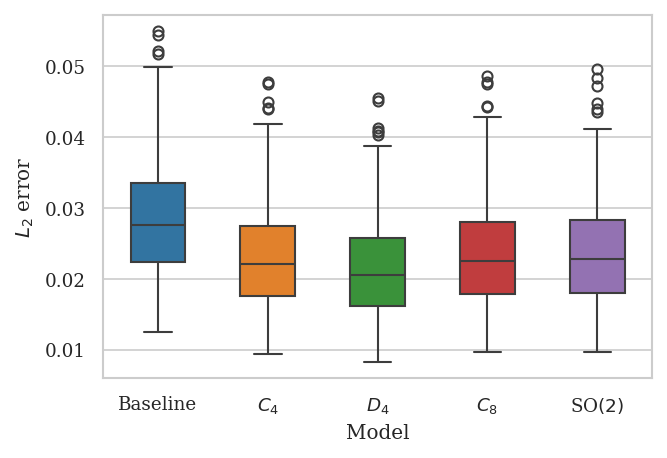

Baseline: 0.0286+-0.0078
      C4: nan+-nan
      D4: nan+-nan
      C8: nan+-nan
   SO(2): nan+-nan


In [28]:
df = pd.read_csv('csv/ner.csv')
df = df.replace(rename_dict)

sns.set_style('whitegrid')
sns.set_context('paper')
plt.rcParams['font.family'] = 'serif'

plt.figure(figsize=(12*cm,8*cm), dpi=150)

sns.boxplot(
    data=df,
    x="Model",
    y="NER",
    hue="Model",
    width=0.5
)
plt.ylabel("$L_2$ error")
plt.savefig('plots/ner_box.pdf')
plt.show()

for model in ["Baseline", "C4", "D4", "C8", "SO(2)"]:
    filtered_df = df[df['Model']==model]
    print(f"{model:>8}: {filtered_df['NER'].mean():.4f}+-{filtered_df['NER'].std():.4f}")

### EER

In [31]:
from escnn import gspaces, nn as enn

models = ["DSCMS_LTP"]
postfix = "_DA"
batch_size = 64
samples = 7000
resolution = 16

dataloader = create_dataloaders(data_dir, 32, resolution, num_workers=0, samples=64)["test"]
N = 24
r2_act = gspaces.rot2dOnR2(N=N)
feat_type = enn.FieldType(r2_act, [r2_act.irrep(1)])

for model_name in models:
    dfs = []
    file_name = f"{model_name}{postfix}_bs{batch_size}_d{samples}_r{resolution}.pt"
    model = create_model(model_name)
    model.to(device)
    model.load_state_dict(torch.load(os.path.join(model_dir, file_name)))
    model.eval()
    for Xs, Ys in tqdm(dataloader):
        Xs, Ys = Xs.to(device), Ys.to(device)
        for i, g in enumerate(r2_act.fibergroup.elements[1:N//4+1]):
            Xs_rot = feat_type(Xs).transform(g).tensor
            preds_in_rot = model(Xs_rot)
            preds = model(Xs)
            preds_out_rot = feat_type(preds).transform(g).tensor
            EER = (torch.linalg.vector_norm((preds_in_rot - preds_out_rot)[:,:,40:88,40:88], dim=(1,2,3)) / torch.linalg.vector_norm(preds_out_rot[:,:,40:88,40:88], dim=(1,2,3))).cpu().detach().numpy()
            del preds_in_rot
            del preds_out_rot
            del preds
            del Xs_rot
            for j in range(3 if i==N//4-1 else 4):
                dfs.append(pd.DataFrame({
                    "Model": model_name,
                    "Rotation": 360//N*(i+1)+90*j,
                    "EER": EER,
                }))
        dfs.append(pd.DataFrame({
            "Model": model_name,
            "Rotation": [0,360],
            "EER": 0.0,
        }))
    del model
    df = pd.concat(dfs, ignore_index=True)
    df.to_csv(f'csv/eer_{model_name}.csv', index=False)

Loaded DSCMS_LTP with 31122 trainable parameters.


  0%|                                                     | 0/2 [00:03<?, ?it/s]


KeyboardInterrupt: 

In [3]:
model_name = "DSCMS_C8"
postfix = "_DA"
batch_size = 64
samples = 7000
resolution = 16
start_epoch = 600
model = create_model(model_name)
file_name = f"{model_name}{postfix}_bs{batch_size}_d{samples}_r{resolution}_e{start_epoch}.tar"
file_path = os.path.join(model_dir, file_name)
checkpoint = torch.load(file_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
torch.save(model.state_dict(), f"{model_dir}/{model_name}{postfix}_bs{batch_size}_d{samples}_r{resolution}.pt")

Loaded DSCMS_C8 with 35588 trainable parameters.


In [2]:
from escnn import gspaces, nn as enn

models = ["DSCMS", "DSCMS_C4", "DSCMS_D4", "DSCMS_C8", "DSCMS_SO2"]
postfix = "_DA"
batch_size = 64
samples = 7000
resolution = 16

dataloader = create_dataloaders(data_dir, 32, resolution, num_workers=0, samples=1000)["test"]
N = 24
r2_act = gspaces.rot2dOnR2(N=N)
feat_type = enn.FieldType(r2_act, [r2_act.irrep(1)])
downsample = torch.nn.AvgPool2d(8)
upsample = torch.nn.Upsample(128, mode="nearest")
def rotate(x, g):
    d = x.shape[3]//4
    x = torch.cat([x[:,:,-d:,:], x, x[:,:,:d,:]], 2)
    x = torch.cat([x[:,:,:,-d:], x, x[:,:,:,:d]], 3)
    x = feat_type(x).transform(g).tensor[:,:,d:-d,d:-d]
    return x

for model_name in models:
    dfs = []
    file_name = f"{model_name}{postfix}_bs{batch_size}_d{samples}_r{resolution}.pt"
    model = create_model(model_name)
    model.to(device)
    model.load_state_dict(torch.load(os.path.join(model_dir, file_name)))
    model.eval()
    for Xs, Ys in tqdm(dataloader):
        Xs, Ys = Xs.to(device), Ys.to(device)
        for i, g in enumerate(r2_act.fibergroup.elements):
            #Xs_rot = downsample(Xs)
            #Xs_rot = rotate(Xs_rot, g)
            #Xs_rot = upsample(Xs_rot)
            Ys_rot = rotate(Ys, g)
            Xs_rot = downsample(Ys_rot)
            Xs_rot = upsample(Xs_rot)
            preds_in_rot = model(Xs_rot)
            preds_out_rot = rotate(model(Xs), g)
            #NER = (torch.linalg.vector_norm(preds_in_rot - Ys_rot, dim=(1,2,3)) / torch.linalg.vector_norm(Ys_rot, dim=(1,2,3))).cpu().detach().numpy()
            EER = (torch.linalg.vector_norm(preds_in_rot - preds_out_rot, dim=(1,2,3)) / torch.linalg.vector_norm(preds_out_rot, dim=(1,2,3))).cpu().detach().numpy()
            del preds_in_rot
            del preds_out_rot
            del Xs_rot
            del Ys_rot
            if i == 0:
                for r in [0, 360]:
                    dfs.append(pd.DataFrame({
                        "Model": model_name,
                        "Rotation": r,
                        #"NER": NER,
                        "EER": EER,
                    }))
            else:
                dfs.append(pd.DataFrame({
                    "Model": model_name,
                    "Rotation": 360//N*i,
                    #"NER": NER,
                    "EER": EER,
                }))
    del model
    df = pd.concat(dfs, ignore_index=True)
    df.to_csv(f'csv/eer2_{model_name}.csv', index=False)

Loaded DSCMS with 38570 trainable parameters.


100%|███████████████████████████████████████████| 32/32 [28:08<00:00, 52.77s/it]


Loaded DSCMS_C4 with 32276 trainable parameters.


100%|███████████████████████████████████████████| 32/32 [28:24<00:00, 53.27s/it]


Loaded DSCMS_D4 with 35588 trainable parameters.


100%|███████████████████████████████████████████| 32/32 [29:05<00:00, 54.55s/it]


Loaded DSCMS_C8 with 35588 trainable parameters.


100%|███████████████████████████████████████████| 32/32 [29:07<00:00, 54.62s/it]


Loaded DSCMS_SO2 with 31490 trainable parameters.


100%|███████████████████████████████████████████| 32/32 [30:01<00:00, 56.28s/it]


0.014934314


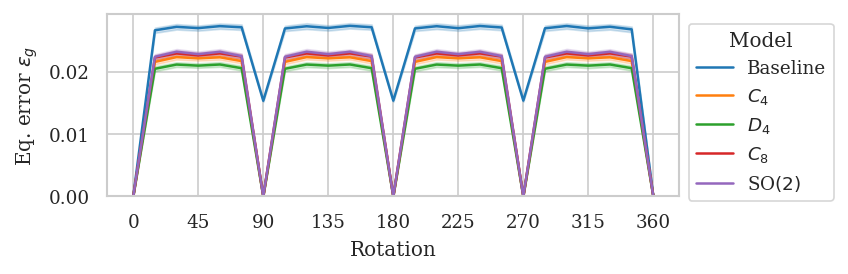

In [27]:
df = pd.concat([pd.read_csv(f'csv/eer2_{model_name}.csv') for model_name in ["DSCMS", "DSCMS_C4", "DSCMS_D4", "DSCMS_C8", "DSCMS_SO2"]], ignore_index=True)
df = df.replace(rename_dict)

#df['EER'] = df['EER'].apply(lambda x: x+1e-4) # log(0) is not defined, so add a very small value)
med = df.query('Model=="Baseline" and Rotation==90')['EER'].median()
print(med)
#print(f"Dashed line at EER={med}")

sns.set_style('whitegrid')
sns.set_context('paper')
plt.rcParams['font.family'] = 'serif'

plt.figure(figsize=(12.5*cm, 4*cm), dpi=150)

g = sns.lineplot(
    data=df,
    x="Rotation",
    y="EER",
    hue="Model",
)
#g.set(yscale="symlog")
plt.ylim(0)
interval = 45
plt.xticks([i*interval for i in range(360//interval+1)])
    #ax.axhline(y=med, color='.3', dashes=(2,2))
plt.ylabel("Eq. error $\epsilon_g$")
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))
#plt.legend(loc='lower left', mode='expand', ncols=5)

plt.savefig('plots/eer.pdf', bbox_inches='tight')
plt.show()

### Training data

In [10]:
from escnn import gspaces, nn as enn

models = ["DSCMS", "DSCMS_C4"]
postfix = "_DA"
batch_size = 64
samples_list = [100, 500, 1000, 4000, 7000]
resolution = 16

dataloader = create_dataloaders(data_dir, 64, resolution, num_workers=0, samples=1000)["test"]
N = 24
r2_act = gspaces.rot2dOnR2(N=N)
feat_type = enn.FieldType(r2_act, [r2_act.irrep(1)])
downsample = torch.nn.AvgPool2d(8)
upsample = torch.nn.Upsample(128, mode="nearest")
def rotate(x, g):
    d = x.shape[3]//4
    x = torch.cat([x[:,:,-d:,:], x, x[:,:,:d,:]], 2)
    x = torch.cat([x[:,:,:,-d:], x, x[:,:,:,:d]], 3)
    x = feat_type(x).transform(g).tensor[:,:,d:-d,d:-d]
    return x

dfs = []
for model_name in models:
    for samples in samples_list:
        file_name = f"{model_name}{postfix}_bs{batch_size}_d{samples}_r{resolution}.pt"
        model = create_model(model_name)
        model.to(device)
        model.load_state_dict(torch.load(os.path.join(model_dir, file_name)))
        model.eval()
        for Xs, Ys in tqdm(dataloader):
            Xs, Ys = Xs.to(device), Ys.to(device)
            for i, g in enumerate(r2_act.fibergroup.elements):
                Ys_rot = rotate(Ys, g)
                Xs_rot = downsample(Ys_rot)
                Xs_rot = upsample(Xs_rot)
                preds_in_rot = model(Xs_rot)
                preds_out_rot = rotate(model(Xs), g)
                NER = (torch.linalg.vector_norm(preds_in_rot - Ys_rot, dim=(1,2,3)) / torch.linalg.vector_norm(Ys, dim=(1,2,3))).cpu().detach().numpy()
                EER = (torch.linalg.vector_norm(preds_in_rot - preds_out_rot, dim=(1,2,3)) / torch.linalg.vector_norm(preds_out_rot, dim=(1,2,3))).cpu().detach().numpy()
                dfs.append(pd.DataFrame({
                    "Model": model_name,
                    "Samples": samples,
                    "Rotation": 360//N*i,
                    "EER": EER,
                    "NER": NER,
                }))
                del preds_in_rot
                del preds_out_rot
                del Xs_rot
                del Ys_rot
            del Xs
            del Ys
        del model
    df = pd.concat(dfs, ignore_index=True)
    df.to_csv('csv/training_size.csv', index=False)

Loaded DSCMS with 38570 trainable parameters.


100%|██████████████████████████████████████████| 16/16 [28:10<00:00, 105.64s/it]


Loaded DSCMS with 38570 trainable parameters.


100%|██████████████████████████████████████████| 16/16 [27:59<00:00, 104.99s/it]


Loaded DSCMS with 38570 trainable parameters.


100%|██████████████████████████████████████████| 16/16 [27:57<00:00, 104.86s/it]


Loaded DSCMS with 38570 trainable parameters.


100%|██████████████████████████████████████████| 16/16 [27:58<00:00, 104.91s/it]


Loaded DSCMS with 38570 trainable parameters.


100%|██████████████████████████████████████████| 16/16 [27:57<00:00, 104.83s/it]


Loaded DSCMS_C4 with 32276 trainable parameters.


100%|██████████████████████████████████████████| 16/16 [28:21<00:00, 106.33s/it]


Loaded DSCMS_C4 with 32276 trainable parameters.


100%|██████████████████████████████████████████| 16/16 [28:22<00:00, 106.39s/it]


Loaded DSCMS_C4 with 32276 trainable parameters.


100%|██████████████████████████████████████████| 16/16 [28:21<00:00, 106.37s/it]


Loaded DSCMS_C4 with 32276 trainable parameters.


100%|██████████████████████████████████████████| 16/16 [28:21<00:00, 106.36s/it]


Loaded DSCMS_C4 with 32276 trainable parameters.


100%|██████████████████████████████████████████| 16/16 [28:21<00:00, 106.34s/it]


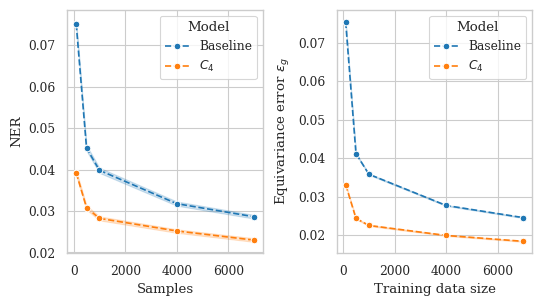

In [26]:
df = pd.read_csv('csv/training_size.csv')
df = df.replace(rename_dict)

sns.set_style('whitegrid')
sns.set_context('paper')
plt.rcParams['font.family'] = 'serif'

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14*cm, 8*cm))

filtered_df = df.query('Rotation==0')
g = sns.lineplot(
    data=filtered_df,
    x="Samples",
    y="NER",
    hue="Model",
    marker="o",
    linestyle="--",
    errorbar=("ci"),
    ax=ax1,
)
#g.set(xscale="log")
y = df.query('Model=="Baseline" and Samples==7000')['NER'].mean()
plt.xlabel("Training data size")
plt.ylabel("$L_2$ error")
#ax.axhline(y=y, color='.3', dashes=(2,2), zorder=0)
sns.move_legend(g, 'upper right')
#g._legend.remove()
#plt.savefig('plots/training_size_ner.pdf', bbox_inches='tight')
#plt.show()

g = sns.lineplot(
    data=df,
    x="Samples",
    y="EER",
    hue="Model",
    marker="o",
    linestyle="--",
    ax=ax2,
)
fig.tight_layout()
plt.xlabel("Training data size")
plt.ylabel("Equivariance error $\epsilon_g$")
sns.move_legend(g, 'upper right')
plt.savefig('plots/training_size.pdf', bbox_inches='tight')

In [3]:
models = ["DSCMS", "DSCMS_C4", "DSCMS_D4", "DSCMS_C8", "DSCMS_SO2"]
names = ["Baseline", "$C_4$", "$D_4$", "$C_8$", "SO$(2)$"]
postfix = "_DA"
batch_size = 64
samples = 7000
resolution = 16

dataloader = create_dataloaders(data_dir, 16, resolution, samples=1000)["test"]
index = 0

Xs, Ys = next(iter(dataloader))
ground_truth = torch.clone(Ys[index]).numpy()
low_res = torch.clone(Xs[index]).numpy()
Xs, Ys = Xs.to(device), Ys.to(device)
images = list()
NERs = list()
for i in [0, 1]:
    for model_name in models:
        file_name = f"{model_name}{postfix}_bs{batch_size}_d{samples}_r{resolution}.pt"
        model = create_model(model_name)
        model.to(device)
        model.load_state_dict(torch.load(os.path.join(model_dir, file_name)))
        model.eval()
        preds = model(Xs)
        images.append(preds[index, i].cpu().detach().numpy().transpose())
        images.append(np.square((preds[index, i]-Ys[index, i]).cpu().detach().numpy().transpose()))
        NERs.append(NER(preds[index, i], Ys[index, i]))
        del preds
        del model

Loaded DSCMS with 38570 trainable parameters.
Loaded DSCMS_C4 with 32276 trainable parameters.
Loaded DSCMS_D4 with 35588 trainable parameters.
Loaded DSCMS_C8 with 35588 trainable parameters.
Loaded DSCMS_SO2 with 31490 trainable parameters.
Loaded DSCMS with 38570 trainable parameters.
Loaded DSCMS_C4 with 32276 trainable parameters.
Loaded DSCMS_D4 with 35588 trainable parameters.
Loaded DSCMS_C8 with 35588 trainable parameters.
Loaded DSCMS_SO2 with 31490 trainable parameters.


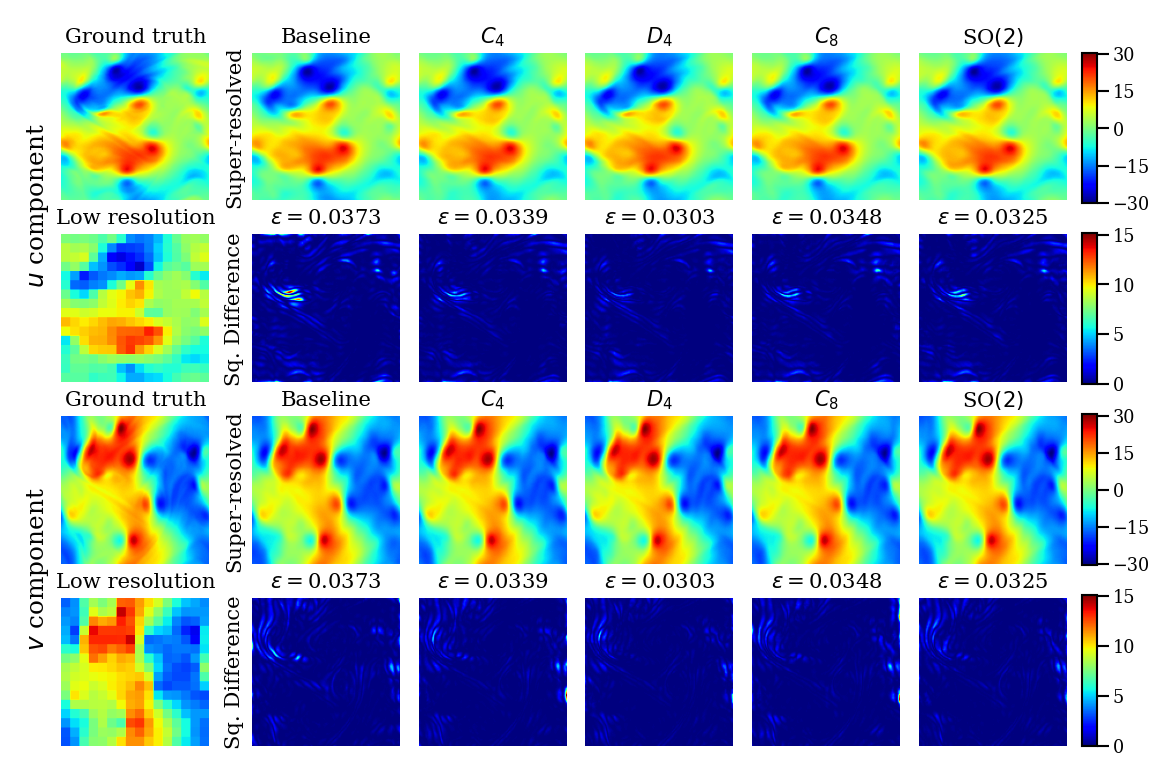

In [25]:
rows, cols = 4, 6
fig, axes = plt.subplots(rows, cols, figsize=(14.5*cm, 9*cm), dpi=254, gridspec_kw={'width_ratios': (1.2, 1, 1, 1, 1, 1)})

fontsize = 6
fontsize_title = 7
fontsize_cbar = 5

plt.rcParams['font.family'] = 'serif'

vmin, vmax = np.min(images[0::2]).item(), np.max(images[0::2]).item()
for i in range(cols):
    ax = axes[0, i]
    if i == 0:
        im = ground_truth[0].transpose()
        ax.text(64, -14, 'Ground truth', va='center', ha='center', fontsize=fontsize)
        ax.text(150, 64, 'Super-resolved', va='center', ha='center', rotation=90, fontsize=fontsize)
        ax.text(-20, 132, '$u$ component', va='center', ha='center', rotation=90, fontsize=fontsize_title)
    else:
        im = images[2*(i-1)]
        ax.text(64, -14, names[i-1], va='center', ha='center', fontsize=fontsize)
    im = ax.imshow(im, cmap='jet', vmin=vmin, vmax=vmax)
    ax.axis('off')
    if i == cols-1:
        cax = fig.add_axes([ax.get_position().x1-0.02,ax.get_position().y0,0.01,ax.get_position().height])
        cbar = plt.colorbar(im, cax=cax, ticks=[-30, -15, 0, 15, 30])
        cbar.ax.tick_params(labelsize=fontsize_cbar)
        cbar.outline.set_linewidth(0.6)
        cbar.ax.tick_params(axis='y', width=0.6)
        cbar.ax.yaxis.set_tick_params(pad=1)

for i in range(cols):
    ax = axes[1, i]
    if i == 0:
        im = low_res[0].transpose()
        ax.text(64, -14, 'Low resolution', va='center', ha='center', fontsize=fontsize)
        ax.text(150, 64, 'Sq. Difference', va='center', ha='center', rotation=90, fontsize=fontsize)
    else:
        vmin, vmax = 0, np.max(images[1::2])
        im = images[2*(i-1)+1]
        ax.text(64, -14, f'$\epsilon=${NERs[i-1+5]:.4f}', va='center', ha='center', fontsize=fontsize)
    im = ax.imshow(im, cmap='jet', vmin=vmin, vmax=vmax)
    ax.axis('off')
    if i == cols-1:
        cax = fig.add_axes([ax.get_position().x1-0.02,ax.get_position().y0,0.01,ax.get_position().height])
        cbar = plt.colorbar(im, cax=cax, ticks=[0, 5, 10, 15])
        cbar.ax.tick_params(labelsize=fontsize_cbar)
        cbar.outline.set_linewidth(0.6)
        cbar.ax.tick_params(axis='y', width=0.6)
        cbar.ax.yaxis.set_tick_params(pad=1)

vmin, vmax = np.min(images[0::2]).item(), np.max(images[0::2]).item()
for i in range(cols):
    ax = axes[2, i]
    if i == 0:
        im = ground_truth[1].transpose()
        ax.text(64, -14, 'Ground truth', va='center', ha='center', fontsize=fontsize)
        ax.text(150, 64, 'Super-resolved', va='center', ha='center', rotation=90, fontsize=fontsize)
        ax.text(-20, 132, '$v$ component', va='center', ha='center', rotation=90, fontsize=fontsize_title)
    else:
        im = images[2*(i-1)+10]
        ax.text(64, -14, names[i-1], va='center', ha='center', fontsize=fontsize)
    im = ax.imshow(im, cmap='jet', vmin=vmin, vmax=vmax)
    ax.axis('off')
    if i == cols-1:
        cax = fig.add_axes([ax.get_position().x1-0.02,ax.get_position().y0,0.01,ax.get_position().height])
        cbar = plt.colorbar(im, cax=cax, ticks=[-30, -15, 0, 15, 30])
        cbar.ax.tick_params(labelsize=fontsize_cbar)
        cbar.outline.set_linewidth(0.6)
        cbar.ax.tick_params(axis='y', width=0.6)
        cbar.ax.yaxis.set_tick_params(pad=1)

for i in range(cols):
    ax = axes[3, i]
    if i == 0:
        im = low_res[1].transpose()
        ax.text(64, -14, 'Low resolution', va='center', ha='center', fontsize=fontsize)
        ax.text(150, 64, 'Sq. Difference', va='center', ha='center', rotation=90, fontsize=fontsize)
    else:
        vmin, vmax = 0, np.max(images[1::2])
        im = images[2*(i-1)+11]
        ax.text(64, -14, f'$\epsilon=${NERs[i-1+5]:.4f}', va='center', ha='center', fontsize=fontsize)
    im = ax.imshow(im, cmap='jet', vmin=vmin, vmax=vmax)
    ax.axis('off')
    if i == cols-1:
        cax = fig.add_axes([ax.get_position().x1-0.02,ax.get_position().y0,0.01,ax.get_position().height])
        cbar = plt.colorbar(im, cax=cax, ticks=[0, 5, 10, 15])
        cbar.ax.tick_params(labelsize=fontsize_cbar)
        cbar.outline.set_linewidth(0.6)
        cbar.ax.tick_params(axis='y', width=0.6)
        cbar.ax.yaxis.set_tick_params(pad=1)

plt.subplots_adjust(wspace=-0.3, hspace=0.23)
plt.savefig('plots/ner_qualitative.pdf', bbox_inches='tight')

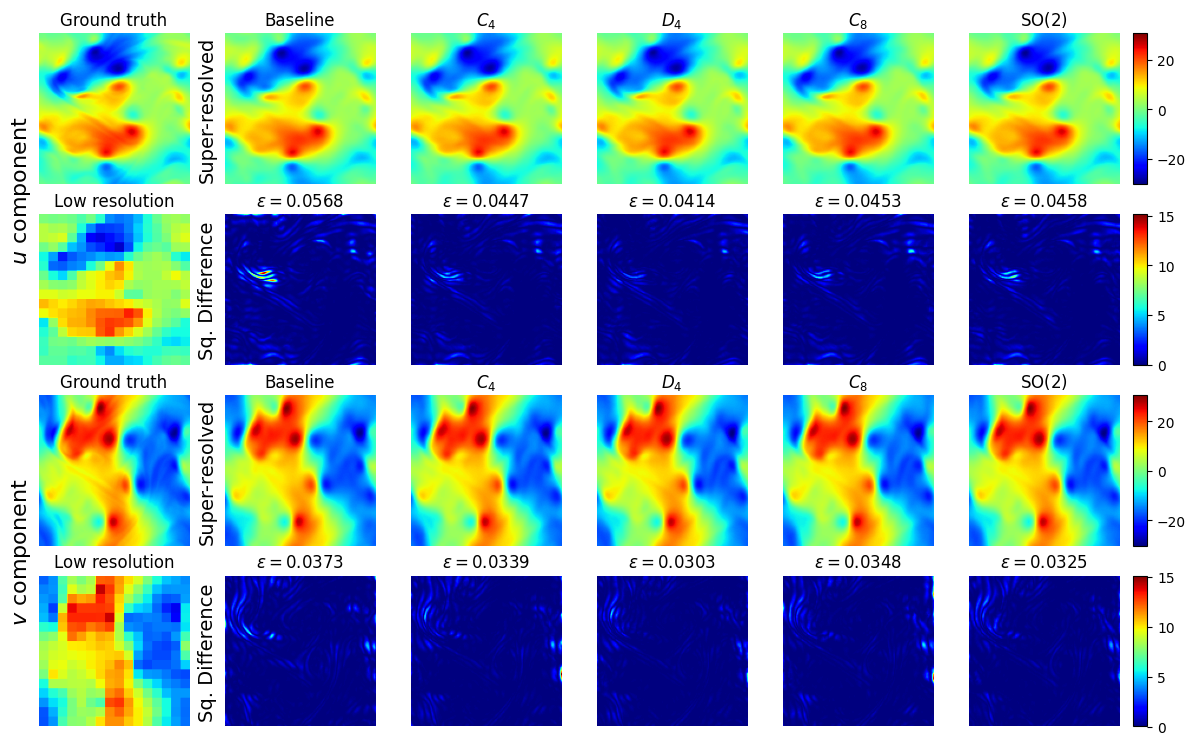

In [60]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

rows, cols = 4, 6
fig, axes = plt.subplots(rows, cols, figsize=(14, 9))

vmin, vmax = np.min(images[0::2]).item(), np.max(images[0::2]).item()
for i in range(cols):
    ax = axes[0, i]
    if i == 0:
        im = ground_truth[0].transpose()
        ax.set_title("Ground truth")
        ax.text(143, 64, 'Super-resolved', va='center', ha='center', rotation=90, fontsize=14)
        ax.text(-15, 132, '$u$ component', va='center', ha='center', rotation=90, fontsize=16)
    else:
        im = images[2*(i-1)]
        ax.set_title(names[i-1])
    im = ax.imshow(im, cmap='jet', vmin=vmin, vmax=vmax)
    ax.axis('off')
    if i == cols-1:
        cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.01,ax.get_position().height])
        plt.colorbar(im, cax=cax)

for i in range(cols):
    ax = axes[1, i]
    if i == 0:
        im = low_res[0].transpose()
        ax.set_title("Low resolution")
        ax.text(143, 64, 'Sq. Difference', va='center', ha='center', rotation=90, fontsize=14)
    else:
        vmin, vmax = np.min(images[1::2]), np.max(images[1::2])
        im = images[2*(i-1)+1]
        ax.set_title(f'$\epsilon=${NERs[i-1]:.4f}')
    im = ax.imshow(im, cmap='jet', vmin=vmin, vmax=vmax)
    ax.axis('off')
    if i == cols-1:
        cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.01,ax.get_position().height])
        plt.colorbar(im, cax=cax)

vmin, vmax = np.min(images[0::2]).item(), np.max(images[0::2]).item()
for i in range(cols):
    ax = axes[2, i]
    if i == 0:
        im = ground_truth[1].transpose()
        ax.set_title("Ground truth")
        ax.text(143, 64, 'Super-resolved', va='center', ha='center', rotation=90, fontsize=14)
        ax.text(-15, 132, '$v$ component', va='center', ha='center', rotation=90, fontsize=16)
    else:
        im = images[2*(i-1)+10]
        ax.set_title(names[i-1])
    im = ax.imshow(im, cmap='jet', vmin=vmin, vmax=vmax)
    ax.axis('off')
    if i == cols-1:
        cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.01,ax.get_position().height])
        plt.colorbar(im, cax=cax)

for i in range(cols):
    ax = axes[3, i]
    if i == 0:
        im = low_res[1].transpose()
        ax.set_title("Low resolution")
        ax.text(143, 64, 'Sq. Difference', va='center', ha='center', rotation=90, fontsize=14)
    else:
        vmin, vmax = np.min(images[1::2]), np.max(images[1::2])
        im = images[2*(i-1)+11]
        ax.set_title(f'$\epsilon=${NERs[i-1+5]:.4f}')
    im = ax.imshow(im, cmap='jet', vmin=vmin, vmax=vmax)
    ax.axis('off')
    if i == cols-1:
        cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.01,ax.get_position().height])
        plt.colorbar(im, cax=cax)
        
plt.savefig('plots/ner_qualitative.pdf', bbox_inches='tight')

In [8]:
from escnn import gspaces, nn as enn

models = ["DSCMS", "DSCMS_C4", "DSCMS_D4", "DSCMS_C8", "DSCMS_SO2"]
postfix = "_DA"
batch_size = 64
samples = 7000
resolution = 16

N = 24
r2_act = gspaces.rot2dOnR2(N=N)
feat_type = enn.FieldType(r2_act, [r2_act.irrep(1)])
downsample = torch.nn.AvgPool2d(8)
upsample = torch.nn.Upsample(128, mode="nearest")
def rotate(x, g):
    d = x.shape[3]//4
    x = torch.cat([x[:,:,-d:,:], x, x[:,:,:d,:]], 2)
    x = torch.cat([x[:,:,:,-d:], x, x[:,:,:,:d]], 3)
    x = feat_type(x).transform(g).tensor[:,:,d:-d,d:-d]
    return x

dfs = list()
for model_name in models:
    test_batch = 16
    dataloader = create_dataloaders(data_dir, test_batch, resolution, num_workers=0, samples=test_batch)["test"]
    file_name = f"{model_name}{postfix}_bs{batch_size}_d{samples}_r{resolution}.pt"
    model = create_model(model_name)
    model.to(device)
    model.load_state_dict(torch.load(os.path.join(model_dir, file_name)))
    model.eval()
    for Xs, Ys in tqdm(dataloader):
        Xs, Ys = Xs.to(device), Ys.to(device)
        for i, g in enumerate(r2_act.fibergroup.elements):
            Ys_rot = rotate(Ys, g)
            Xs_rot = downsample(Ys_rot)
            Xs_rot = upsample(Xs_rot)
            preds_in_rot = model(Xs_rot)
            preds_out_rot = rotate(model(Xs), g)
            EER = (torch.linalg.vector_norm(preds_in_rot - preds_out_rot, dim=(1,2,3)) / torch.linalg.vector_norm(Ys_rot, dim=(1,2,3))).cpu().detach().numpy()
            del preds_in_rot
            del preds_out_rot
            del Xs_rot
            del Ys_rot
            if i == 0:
                for r in [0, 360]:
                    dfs.append(pd.DataFrame({
                        "Model": model_name,
                        "Rotation": r,
                        "EER": EER,
                        "index": range(test_batch),
                    }))
            else:
                dfs.append(pd.DataFrame({
                    "Model": model_name,
                    "Rotation": 360//N*i,
                    "EER": EER,
                    "index": range(test_batch),
                }))
    del model
df = pd.concat(dfs)
df.to_csv('csv/eer_qualitative.csv', index=False)

Loaded DSCMS with 38570 trainable parameters.


100%|█████████████████████████████████████████████| 1/1 [00:27<00:00, 28.00s/it]


Loaded DSCMS_C4 with 32276 trainable parameters.


100%|█████████████████████████████████████████████| 1/1 [00:28<00:00, 28.58s/it]


Loaded DSCMS_D4 with 35588 trainable parameters.


100%|█████████████████████████████████████████████| 1/1 [00:29<00:00, 29.12s/it]


Loaded DSCMS_C8 with 35588 trainable parameters.


100%|█████████████████████████████████████████████| 1/1 [00:29<00:00, 29.18s/it]


Loaded DSCMS_SO2 with 31490 trainable parameters.


100%|█████████████████████████████████████████████| 1/1 [00:29<00:00, 29.77s/it]


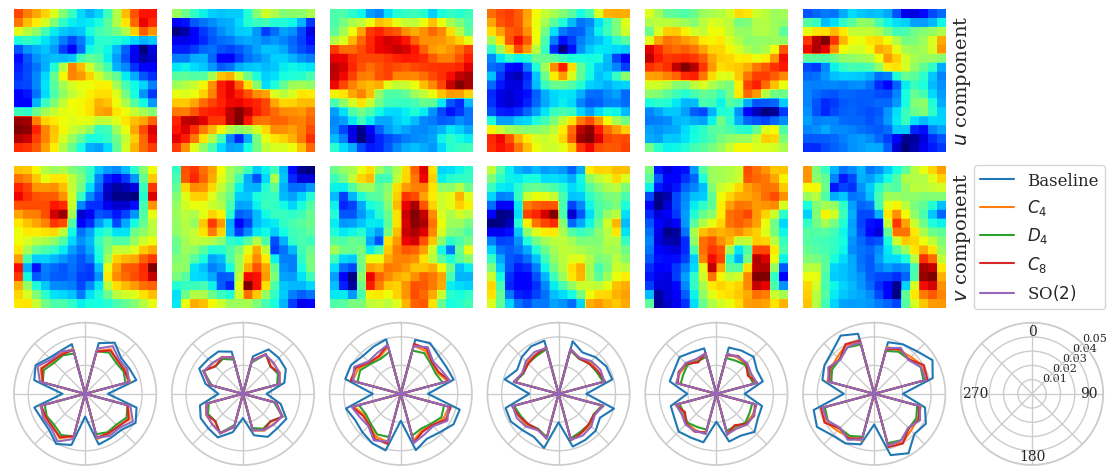

In [54]:
models = ["DSCMS", "DSCMS_C4", "DSCMS_D4", "DSCMS_C8", "DSCMS_SO2"]
model_names = ["Baseline", "$C_4$", "$D_4$", "$C_8$", "SO$(2)$"]
indices = ['a', 'b', 'c', 'd', 'e', 'f', 'g']

df = pd.read_csv('csv/eer_qualitative.csv')

offset = 1
rows, cols = 3, 7
fig, axes = plt.subplots(rows, cols, figsize=(11.5, 5))

dataloader = create_dataloaders(data_dir, 32, 16, num_workers=0, samples=32)["test"]
Xs, _ = next(iter(dataloader))

plt.rcParams['font.family'] = 'serif'

X = np.arange(128)
Y = np.arange(128)
for j in range(2):
    for i in range(cols-1):
        ax = axes[j, i]
        ax.imshow(Xs[i+offset, j].numpy().transpose(), cmap='jet')
        #ax.streamplot(X, Y, Ys[i+offset, 0], Ys[i+offset, 1], density=0.8, linewidth=0.8, broken_streamlines=True)
        ax.axis('off')
for i in range(cols-1):
    axes[2, i].axis('off')
    ax = axes[2, i] = plt.subplot(rows, cols, i+2*cols+1, projection='polar')
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_ylim(0, 0.05)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    for j, model_name in enumerate(models):
        filtered_df = df.query(f'Model=="{model_name}" and index=={i+offset}')
        filtered_df = filtered_df.sort_values(by='Rotation', ascending=True)
        ax.plot(filtered_df['Rotation']/360*2*np.pi, filtered_df['EER'], label=model_names[j])
        #ax.text(0.5, -0.14, f'({indices[i]})', va='center', ha='center', transform=plt.gca().transAxes)

handles, labels = axes[2, 5].get_legend_handles_labels() 
axes[0, cols-1].axis('off')
axes[1, cols-1].axis('off')
axes[2, cols-1].axis('off')
axes[1, cols-1].legend(handles, labels, loc='center', fontsize=12, bbox_to_anchor=(0.55, 0.5))
axes[0, cols-1].text(0.04, 0.5, '$u$ component', va='center', ha='center', rotation=90, fontsize=14)
axes[1, cols-1].text(0.04, 0.5, '$v$ component', va='center', ha='center', rotation=90, fontsize=14)

axes[2, cols-1] = plt.subplot(rows, cols, 21, projection='polar')
axes[2, cols-1].set_ylim(0, 0.05)
#axes[2, cols-1].set_yticklabels([0.02, 0.04])
axes[2, cols-1].set_xticklabels([])
axes[2, cols-1].set_rlabel_position(45)
axes[2, cols-1].tick_params(axis='y', labelsize=8)
#axes[2, cols-1].grid(False)
axes[2, cols-1].text(0.5, 0.94, '0', va='center', ha='center', fontsize=10, transform=plt.gca().transAxes)
axes[2, cols-1].text(0.9, 0.5, '90', va='center', ha='center', fontsize=10, transform=plt.gca().transAxes)
axes[2, cols-1].text(0.5, 0.06, '180', va='center', ha='center', fontsize=10, transform=plt.gca().transAxes)
axes[2, cols-1].text(0.1, 0.5, '270', va='center', ha='center', fontsize=10, transform=plt.gca().transAxes)

plt.tight_layout()
fig.subplots_adjust(wspace=0.05, hspace=0.1)
plt.savefig('plots/eer_qualitative.pdf', bbox_inches='tight')

### Learning curves

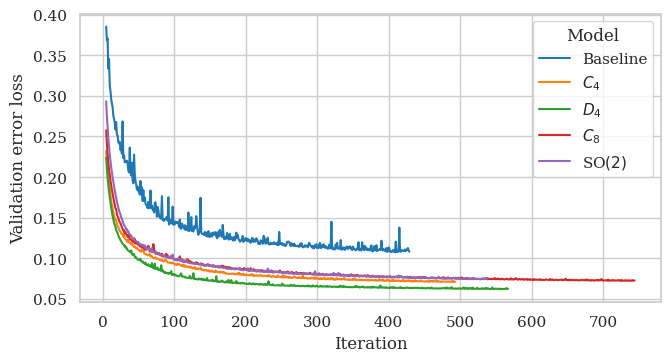

In [31]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt

def load_event_data(event_file):
    event_acc = tf.compat.v1.train.summary_iterator(event_file)
    data = {'step': [], 'relative': [], 'value': []}
    first_timestamp = None
    for event in event_acc:
        if first_timestamp is None:
            first_timestamp = event.wall_time
        for value in event.summary.value:
            if value.tag == 'Loss/valid':
                data['step'].append(event.step)
                data['relative'].append(event.wall_time - first_timestamp)
                data['value'].append(value.simple_value)
    return data

models = ['DSCMS', 'DSCMS_C4', 'DSCMS_D4', 'DSCMS_C8', 'DSCMS_SO2']

dfs = list()
for model_name in models:
    directory = f'runs/{model_name}_DA_bs64_d7000_r16'
    data = {'step': [], 'relative': [], 'value': []}
    for filename in os.listdir(directory):
        if filename.startswith("events"):
            event_file = os.path.join(directory, filename)
            event_data = load_event_data(event_file)
            data['step'].extend(event_data['step'])
            data['relative'].extend(event_data['relative'])
            data['value'].extend(event_data['value'])
        dfs.append(pd.DataFrame({
            'Model': model_name,
            'step': data['step'][5:],
            'relative': data['relative'][5:],
            'value': data['value'][5:],
        }))
df = pd.concat(dfs, ignore_index=True)
df = df.replace(rename_dict)

sns.set_style('whitegrid')
sns.set_context('notebook')
plt.rcParams['font.family'] = 'serif'

plt.figure(figsize=(10/8*6, 5/8*6))

g = sns.lineplot(
    data=df,
    x="step",
    y="value",
    hue="Model",
    errorbar=None,
)
#g.set(yscale="log")
sns.move_legend(g, 'upper right')
plt.xlabel('Iteration')
plt.ylabel('Validation error loss')
plt.savefig('plots/train.pdf', bbox_inches='tight')
plt.show()

# DSC/MS:  4.220 hr
# C4:      7.401 hr
# D4:     13.700 hr
# C8:     17.629 hr
# SO(2):  13.906 hr

### Rotated Input

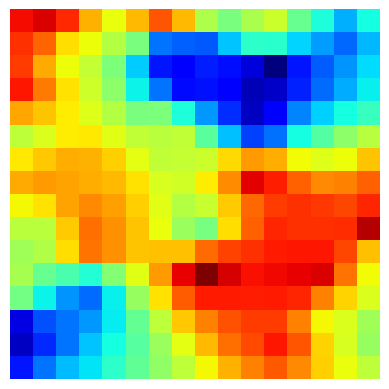

In [10]:
model_name = "DSCMS_C4"
postfix = "_DA"
batch_size = 64
resolution = 16
samples=7000
dataloader = create_dataloaders(data_dir, batch_size, resolution, samples=1000)["test"]
Xs, Ys = next(iter(dataloader))

r2_act = gspaces.rot2dOnR2(N=8)
feat_type = enn.FieldType(r2_act, [r2_act.irrep(1)])

# Naive approach
Xs_rot = Xs.to(device)
Xs_rot = feat_type(Xs).transform(r2_act.fibergroup.elements[1]).tensor
Xs_rot = Xs_rot.cpu().detach().numpy()
plt.imshow(Xs_rot[0, 0].transpose(), cmap='jet', interpolation='nearest')
plt.gca().axis('off')
plt.savefig('plots/rotating0.png', bbox_inches='tight', pad_inches=0)
#plt.show()

# Downsample
Xs = torch.nn.MaxPool2d(8)(Xs)
plt.imshow(Xs[0, 0].numpy().transpose(), cmap='jet', interpolation='nearest')
plt.gca().axis('off')
plt.savefig('plots/rotating1.png', bbox_inches='tight', pad_inches=0)
#plt.show()

# Extend
Xs = torch.cat([Xs[:,:,-4:], Xs, Xs[:,:,:4]], 2)
Xs = torch.cat([Xs[:,:,:,-4:], Xs, Xs[:,:,:,:4]], 3)
plt.imshow(Xs[0, 0].numpy().transpose(), cmap='jet', interpolation='nearest')
plt.gca().axis('off')
plt.savefig('plots/rotating2.png', bbox_inches='tight', pad_inches=0)
#plt.show()

# Rotate
Xs = Xs.to(device)
Xs_rot = feat_type(Xs).transform(r2_act.fibergroup.elements[1]).tensor
Xs_rot = Xs_rot.cpu().detach()
plt.imshow(Xs_rot[0, 0].numpy().transpose(), cmap='jet', interpolation='nearest')
plt.gca().axis('off')
plt.savefig('plots/rotating3.png', bbox_inches='tight', pad_inches=0)
#plt.show()

# Cut and upsample
Xs_rot = torch.nn.Upsample(128, mode="nearest")(Xs_rot[:,:,4:-4,4:-4])
Xs_rot = Xs_rot.cpu().detach().numpy()
plt.imshow(Xs_rot[0, 0].transpose(), cmap='jet', interpolation='nearest')
plt.gca().axis('off')
plt.savefig('plots/rotating4.png', bbox_inches='tight', pad_inches=0)
#plt.show()


torch.Size([32, 2, 128, 128])


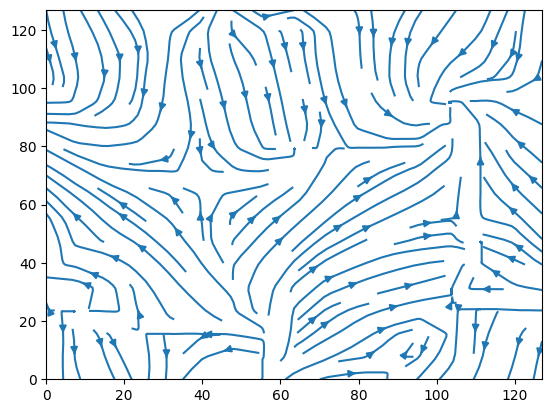

In [10]:
dataloader = create_dataloaders(data_dir, 32, 16, num_workers=0, samples=32)["test"]
Xs, Ys = next(iter(dataloader))

scale = 1
X = np.arange(128//scale)
Y = np.arange(128//scale)
print(Ys[::scale, ::scale].shape)
#plt.quiver(X, Y, Ys[0, 0, ::scale, ::scale], Ys[0, 0, ::scale, ::scale])
plt.streamplot(X, Y, Xs[0, 0], Xs[0, 1])